# Naive RAG

**절차**

1. Naive RAG 수행

![langgraph-naive-rag](assets/langgraph-naive-rag.png)

## 환경 설정

In [ ]:
# !pip install -U langchain-teddynote

In [1]:
# API 키를 환경변수로 관리하기 위한 설정 파일
from dotenv import load_dotenv

# API 키 정보 로드
load_dotenv()

True

In [2]:
# LangSmith 추적을 설정합니다. https://smith.langchain.com
# !pip install -qU langchain-teddynote
from langchain_teddynote import logging

# 프로젝트 이름을 입력합니다.
logging.langsmith("CH17-LangGraph-Structures")

LangSmith 추적을 시작합니다.
[프로젝트명]
CH17-LangGraph-Structures


## 기본 PDF 기반 Retrieval Chain 생성

여기서는 PDF 문서를 기반으로 Retrieval Chain 을 생성합니다. 가장 단순한 구조의 Retrieval Chain 입니다.

단, LangGraph 에서는 Retirever 와 Chain 을 따로 생성합니다. 그래야 각 노드별로 세부 처리를 할 수 있습니다.

In [3]:
from rag.pdf import PDFRetrievalChain

# PDF 문서를 로드합니다.
pdf = PDFRetrievalChain(["data/SPRI_AI_Brief_2023년12월호_F.pdf"]).create_chain()

# retriever와 chain을 생성합니다.
pdf_retriever = pdf.retriever
pdf_chain = pdf.chain

먼저, pdf_retriever 를 사용하여 검색 결과를 가져옵니다.

In [4]:
search_result = pdf_retriever.invoke("앤스로픽에 투자한 기업과 투자금액을 알려주세요.")
search_result

[Document(id='b0bac208-29b2-4421-b1dc-c237169d9d58', metadata={'source': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'file_path': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'page': 13, 'total_pages': 23, 'Author': 'dj', 'Creator': 'Hwp 2018 10.0.0.13462', 'Producer': 'Hancom PDF 1.3.0.542', 'CreationDate': "D:20231208132838+09'00'", 'ModDate': "D:20231208132838+09'00'", 'PDFVersion': '1.4'}, page_content='1. 정책/법제 2. 기업/산업 3. 기술/연구 4. 인력/교육\n구글, 앤스로픽에 20억 달러 투자로 생성 AI 협력 강화\nKEY Contents\nn 구글이 앤스로픽에 최대 20억 달러 투자에 합의하고 5억 달러를 우선 투자했으며, 앤스로픽은\n구글과 클라우드 서비스 사용 계약도 체결\nn 3대 클라우드 사업자인 구글, 마이크로소프트, 아마존은 차세대 AI 모델의 대표 기업인\n앤스로픽 및 오픈AI와 협력을 확대하는 추세\n£구글, 앤스로픽에 최대 20억 달러 투자 합의 및 클라우드 서비스 제공'),
 Document(id='9c9c1957-1d16-416c-aa82-7384f234b119', metadata={'source': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'file_path': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'page': 13, 'total_pages': 23, 'Author': 'dj', 'Creator': 'Hwp 2018 10.0.0.13462', 'Producer': 'Hancom PDF 1.3.0.542', 'CreationDate': "D:20231208132838+0

이전에 검색한 결과를 chain 의 context 로 전달합니다.

In [5]:
# 검색 결과를 기반으로 답변을 생성합니다.
answer = pdf_chain.invoke(
    {
        "question": "앤스로픽에 투자한 기업과 투자금액을 알려주세요.",
        "context": search_result,
        "chat_history": [],
    }
)
print(answer)

구글은 앤스로픽에 최대 20억 달러를 투자하기로 합의하였으며, 이 중 5억 달러를 우선 투자했습니다. 또한, 아마존은 앤스로픽에 최대 40억 달러의 투자 계획을 공개했습니다.

**Source**
- data/SPRI_AI_Brief_2023년12월호_F.pdf (page 13)


## State 정의

`State`: Graph 의 노드와 노드 간 공유하는 상태를 정의합니다.

일반적으로 `TypedDict` 형식을 사용합니다.

In [6]:
from typing import Annotated, TypedDict
from langgraph.graph.message import add_messages


# GraphState 상태 정의
class GraphState(TypedDict):
    question: Annotated[str, "Question"]  # 질문
    context: Annotated[str, "Context"]  # 문서의 검색 결과
    answer: Annotated[str, "Answer"]  # 답변
    messages: Annotated[list, add_messages]  # 메시지(누적되는 list)

## 노드(Node) 정의

- `Nodes`: 각 단계를 처리하는 노드입니다. 보통은 Python 함수로 구현합니다. 입력과 출력이 상태(State) 값입니다.
  
**참고**  

- `State`를 입력으로 받아 정의된 로직을 수행한 후 업데이트된 `State`를 반환합니다.

In [8]:
from langchain_teddynote.messages import messages_to_history
from rag.utils import format_docs


# 문서 검색 노드
def retrieve_document(state: GraphState) -> GraphState:
    # 질문을 상태에서 가져옵니다.
    latest_question = state["question"]

    # 문서에서 검색하여 관련성 있는 문서를 찾습니다.
    retrieved_docs = pdf_retriever.invoke(latest_question)

    # 검색된 문서를 형식화합니다.(프롬프트 입력으로 넣어주기 위함)
    retrieved_docs = format_docs(retrieved_docs)

    # 검색된 문서를 context 키에 저장합니다.
    return {"context": retrieved_docs}


# 답변 생성 노드
def llm_answer(state: GraphState) -> GraphState:
    # 질문을 상태에서 가져옵니다.
    latest_question = state["question"]

    # 검색된 문서를 상태에서 가져옵니다.
    context = state["context"]

    # 체인을 호출하여 답변을 생성합니다.
    response = pdf_chain.invoke(
        {
            "question": latest_question,
            "context": context,
            "chat_history": messages_to_history(state["messages"]),
        }
    )
    # 생성된 답변, (유저의 질문, 답변) 메시지를 상태에 저장합니다.
    return {
        "answer": response,
        "messages": [("user", latest_question), ("assistant", response)],
    }

## 그래프 생성

- `Edges`: 현재 `State`를 기반으로 다음에 실행할 `Node`를 결정하는 Python 함수.

일반 엣지, 조건부 엣지 등이 있습니다.

In [9]:
from langgraph.graph import END, StateGraph
from langgraph.checkpoint.memory import MemorySaver

# 그래프 생성
workflow = StateGraph(GraphState)

# 노드 정의
workflow.add_node("retrieve", retrieve_document)
workflow.add_node("llm_answer", llm_answer)

# 엣지 정의
workflow.add_edge("retrieve", "llm_answer")  # 검색 -> 답변
workflow.add_edge("llm_answer", END)  # 답변 -> 종료

# 그래프 진입점 설정
workflow.set_entry_point("retrieve")

# 체크포인터 설정
memory = MemorySaver()

# 컴파일
app = workflow.compile(checkpointer=memory)

컴파일한 그래프를 시각화 합니다.

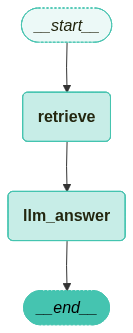

In [10]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(app)

## 그래프 실행

- `config` 파라미터는 그래프 실행 시 필요한 설정 정보를 전달합니다.
- `recursion_limit`: 그래프 실행 시 재귀 최대 횟수를 설정합니다.
- `inputs`: 그래프 실행 시 필요한 입력 정보를 전달합니다.

**참고**

- 메시지 출력 스트리밍은 [LangGraph 스트리밍 모드의 모든 것](https://wikidocs.net/265770) 을 참고해주세요.

아래의 `stream_graph` 함수는 특정 노드만 스트리밍 출력하는 함수입니다.

손쉽게 특정 노드의 스트리밍 출력을 확인할 수 있습니다.

In [13]:
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import invoke_graph, stream_graph, random_uuid

# config 설정(재귀 최대 횟수, thread_id)
config = RunnableConfig(recursion_limit=20, configurable={"thread_id": random_uuid()})

# 질문 입력
inputs = GraphState(question="앤스로픽에 투자한 기업과 투자금액을 알려주세요.")

# 그래프 실행
invoke_graph(app, inputs, config)


🔄 Node: retrieve 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
context:
<document><content>1. 정책/법제 2. 기업/산업 3. 기술/연구 4. 인력/교육
구글, 앤스로픽에 20억 달러 투자로 생성 AI 협력 강화
KEY Contents
n 구글이 앤스로픽에 최대 20억 달러 투자에 합의하고 5억 달러를 우선 투자했으며, 앤스로픽은
구글과 클라우드 서비스 사용 계약도 체결
n 3대 클라우드 사업자인 구글, 마이크로소프트, 아마존은 차세대 AI 모델의 대표 기업인
앤스로픽 및 오픈AI와 협력을 확대하는 추세
£구글, 앤스로픽에 최대 20억 달러 투자 합의 및 클라우드 서비스 제공</content><source>data/SPRI_AI_Brief_2023년12월호_F.pdf</source><page>14</page></document>
<document><content>£구글, 앤스로픽에 최대 20억 달러 투자 합의 및 클라우드 서비스 제공
n 구글이 2023년 10월 27일 앤스로픽에 최대 20억 달러를 투자하기로 합의했으며, 이 중 5억
달러를 우선 투자하고 향후 15억 달러를 추가로 투자할 방침
∙ 구글은 2023년 2월 앤스로픽에 이미 5억 5,000만 달러를 투자한 바 있으며, 아마존도 지난 9월
앤스로픽에 최대 40억 달러의 투자 계획을 공개
∙ 한편, 2023년 11월 8일 블룸버그 보도에 따르면 앤스로픽은 구글의 클라우드 서비스 사용을 위해
4년간 30억 달러 규모의 계약을 체결</content><source>data/SPRI_AI_Brief_2023년12월호_F.pdf</source><page>14</page></document>
<document><content>4년간 30억 달러 규모의 계약을 체결
∙ 오픈AI 창업자 그룹의 일원이었던 다리오(Dario Amodei)와 다니엘라 아모데이(Daniela Amodei)
남매가 2021년 설립한 앤스로픽은 챗GPT의 

In [14]:
# 그래프를 스트리밍 출력
stream_graph(app, inputs, config)


🔄 Node: llm_answer 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
구글은 앤스로픽에 최대 20억 달러를 투자하기로 합의하고, 이 중 5억 달러를 우선 투자했습니다. 아마존은 앤스로픽에 최대 40억 달러의 투자 계획을 발표했습니다.

**Source**
- data/SPRI_AI_Brief_2023년12월호_F.pdf (page 14)

In [15]:
outputs = app.get_state(config).values

print(f'Question: {outputs["question"]}')
print("===" * 20)
print(f'Answer:\n{outputs["answer"]}')

Question: 앤스로픽에 투자한 기업과 투자금액을 알려주세요.
Answer:
구글은 앤스로픽에 최대 20억 달러를 투자하기로 합의하고, 이 중 5억 달러를 우선 투자했습니다. 아마존은 앤스로픽에 최대 40억 달러의 투자 계획을 발표했습니다.

**Source**
- data/SPRI_AI_Brief_2023년12월호_F.pdf (page 14)
